In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
pd.options.mode.chained_assignment = None  # default='warn'
import pickle

In [33]:
data = pd.read_csv('metadata.csv')
data

,ID,Class,Path,Band
0,1.3319.10,LPV,1.3319.10.dat,1.0
1,1.3441.15,Cep_0,1.3441.15.dat,1.0
2,1.3441.25,LPV,1.3441.25.dat,1.0
3,1.3441.45,Cep_0,1.3441.45.dat,1.0
4,1.3441.1031,RRab,1.3441.1031.dat,1.0
...,...,...,...,...
21439,9.5608.870,RRab,9.5608.870.dat,1.0
21440,9.5608.946,RRab,9.5608.946.dat,1.0
21441,9.5609.22,EC,9.5609.22.dat,1.0
21442,9.5609.790,RRab,9.5609.790.dat,1.0


In [34]:
df = data[data['Class'] == 'RRab'].reset_index(drop=True)
df.head()

,ID,Class,Path,Band
0,1.3441.1031,RRab,1.3441.1031.dat,1.0
1,1.3442.503,RRab,1.3442.503.dat,1.0
2,1.3442.1051,RRab,1.3442.1051.dat,1.0
3,1.3442.1107,RRab,1.3442.1107.dat,1.0
4,1.3442.1243,RRab,1.3442.1243.dat,1.0


In [36]:
stars = dict()
availables = list()
for i in range(len(df['Path'])):
  path = df['Path'][i]
  path_reg = 'RRab_fase_regulares/' + path + '_' + str('regular_phased.pkl')
  with open(path_reg, 'rb') as file:
    # Llama al método load para deserializar
    datos = pickle.load(file)
  availables.append(path)
  stars[path] = datos

In [37]:
print(len(availables))
df_star = stars['1.3442.1243.dat']
df_star

7397


,phase,mag
0,0.002229,-5.015000
1,0.004635,-5.277673
2,0.007042,-5.230566
3,0.009448,-5.207772
4,0.011854,-4.803603
...,...,...
410,0.988813,-5.130105
411,0.991219,-5.146885
412,0.993625,-4.715542
413,0.996032,-5.053955


Equation for AR model : <br>
![alt text](https://i.stack.imgur.com/cj6yX.png)

In [38]:
def AR(p,df):
  df_temp = df

  #Generating the lagged p terms
  for i in range(1,p+1):
    df_temp['Shifted_mag_%d' % i ] = df_temp['mag'].shift(i)

  train_size = (int)(0.7 * df_temp.shape[0])

  #Breaking data set into test and training
  df_train = pd.DataFrame(df_temp[0:train_size])
  df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])

  df_train_droped = df_train.dropna()
  #X contains the lagged values ,hence we skip the first column
  X_train = df_train_droped.iloc[:,1:].values.reshape(-1,p)
  #Y contains the value,it is the first column
  y_train = df_train_droped.iloc[:,0].values.reshape(-1,1)

  #Running linear regression to generate the coefficents of lagged terms
  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  df_train_droped['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
  # df_train_droped[['Value','Predicted_Values']].plot()

  X_test = df_test.iloc[:,1:].values.reshape(-1,p)
  df_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
  # df_test[['Value','Predicted_Values']].plot()

  RMSE = np.sqrt(mean_squared_error(df_test['mag'], df_test['Predicted_Values']))

  print("The RMSE is :", RMSE,", Value of p : ",p)
  return [df_train_droped,df_test,theta,intercept,RMSE]

In [39]:
def MA(q,res):

  for i in range(1,q+1):
    res['Shifted_values_%d' % i ] = res['Residuals'].shift(i)

  train_size = (int)(0.8 * res.shape[0])

  res_train = pd.DataFrame(res[0:train_size])
  res_test = pd.DataFrame(res[train_size:res.shape[0]])

  res_train_2 = res_train.dropna()
  X_train = res_train_2.iloc[:,1:].values.reshape(-1,q)
  y_train = res_train_2.iloc[:,0].values.reshape(-1,1)

  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
  # res_train_2[['Residuals','Predicted_Values']].plot()

  X_test = res_test.iloc[:,1:].values.reshape(-1,q)
  res_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
  res_test[['Residuals','Predicted_Values']].plot()

  from sklearn.metrics import mean_squared_error
  RMSE = np.sqrt(mean_squared_error(res_test['Residuals'], res_test['Predicted_Values']))

  print("The RMSE is :", RMSE,", Value of q : ",q)
  return [res_train_2,res_test,theta,intercept,RMSE]



In [40]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary \n")

<h1>
We break down the ARIMA Model into 3 steps:

1. Making the data stationary by differencing. (I)
2. Fitting an AR model. (AR)
3. Fitting an MA model on the residuals. (MA)
4. Getting Back Original data

</h1>

#Step 1 : Making the data stationary

Different techniques can be used to make the data stationary, used log and differencing. The additional diff(12) is remove the seasonality.

In [41]:
def qqplot(data):
    m = data.mean()
    st = data.std()

    # Standardize the data
    for i in range(0,data.shape[0],1):
        data.iloc[i] = (data.iloc[i]-m)/st

    # determine standard quantiles from the standard normal data

    mu, sigma = 0, 1 # mean and standard deviation
    s = np.random.normal(mu, sigma, len(data))
    q = []
    j=0
    for i in range(1,len(s)+1,1):
        j=i/data.shape[0]
        q_temp = np.quantile(s, j)
        q.append(q_temp)

    fig, ax = plt.subplots(figsize=(10, 8))
    plt.plot(q,sorted(data),'o')
    plt.plot(s,s, '-')
    plt.xlabel("Quantile of standard normal distribution")
    plt.ylabel("Sample Z-score")
    plt.title('Q-Q Plot')
    plt.grid()
    plt.show()

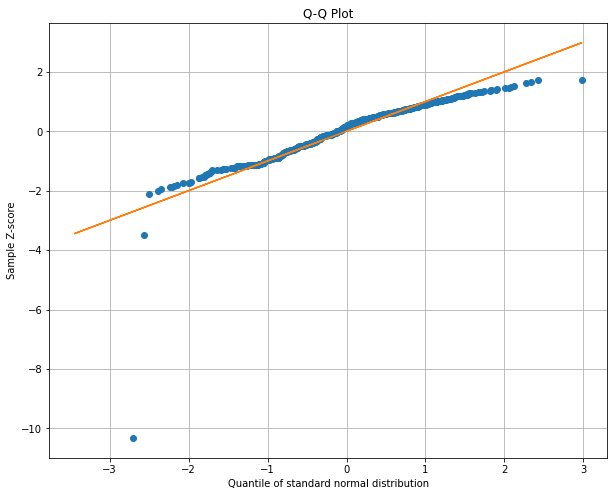

In [10]:
qqplot(df_star['mag'])

In [67]:
df_testing = pd.DataFrame((df_star.mag)) #.diff().diff(12)
df_testing

,mag
0,-5.015000
1,-5.277673
2,-5.230566
3,-5.207772
4,-4.803603
...,...
410,-5.130105
411,-5.146885
412,-4.715542
413,-5.053955


In [69]:
df_testing.mag

0     -5.015000
1     -5.277673
2     -5.230566
3     -5.207772
4     -4.803603
         ...   
410   -5.130105
411   -5.146885
412   -4.715542
413   -5.053955
414   -5.071000
Name: mag, Length: 415, dtype: float64

In [70]:
adf_check(df_testing.mag.dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -9.884270629451514
p-value : 3.699628105691192e-17
Number of Lags Used : 0
Number of Observations Used : 414
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [71]:
def plot_serie(df, savefig=0, show=1, typetime = 'phase'):
    plt.figure(figsize = (40,10))
    plt.plot(df[typetime], df['mag'], '.-')
    plt.ylabel('magnitud')
    plt.tick_params(labelrotation=45)
    plt.text.usetex = True
    if savefig:
        plt.savefig(format = 'svg')
    if show:
        plt.show()

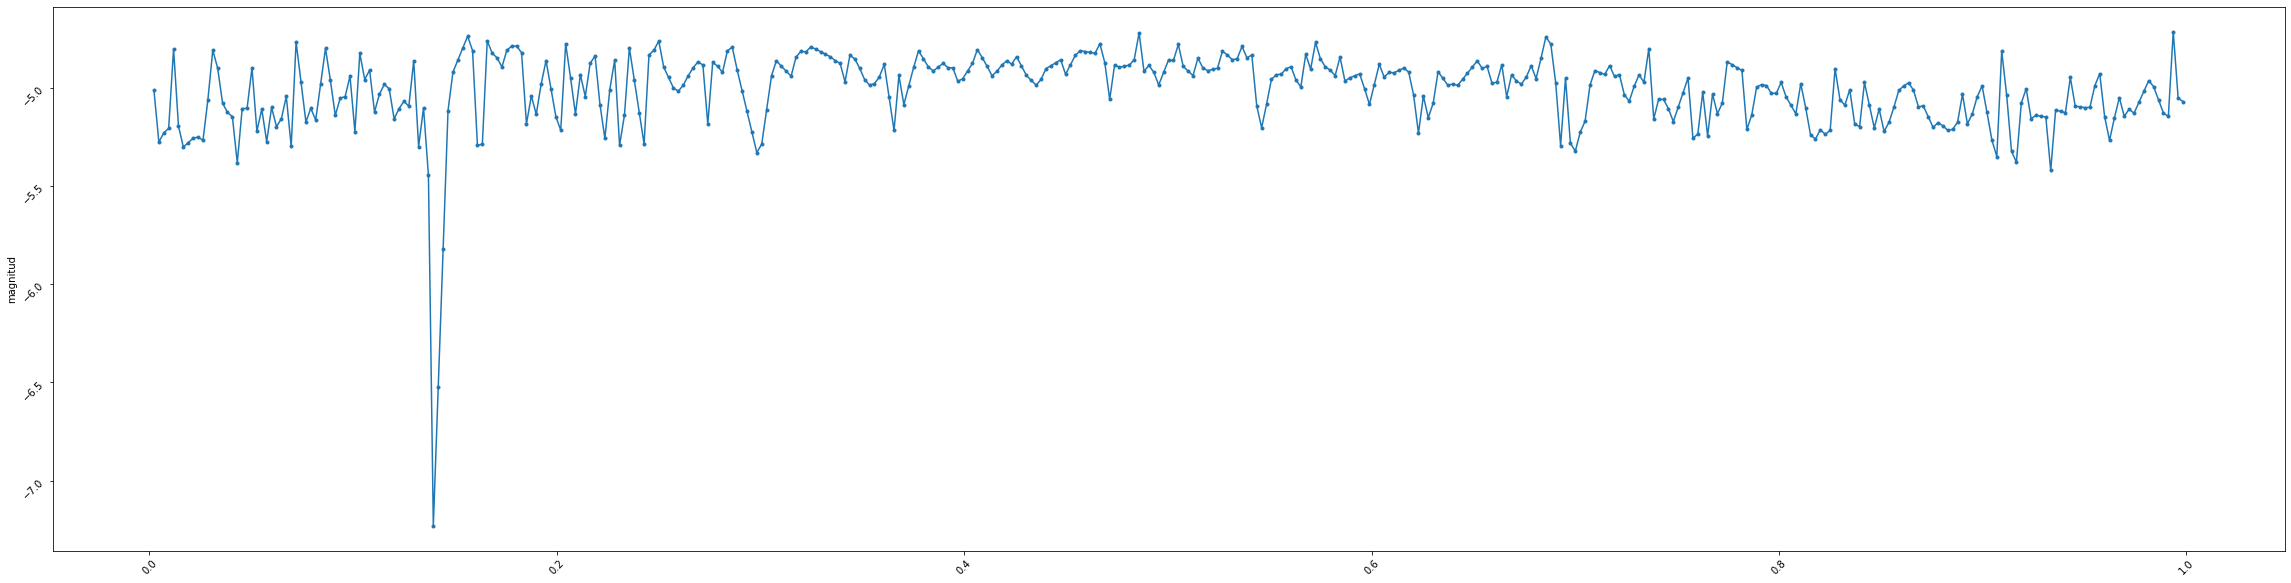

In [72]:
# print(df_testing.to_string())
plot_serie(df_star)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


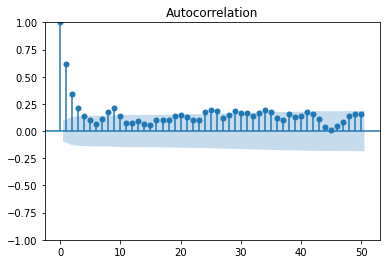

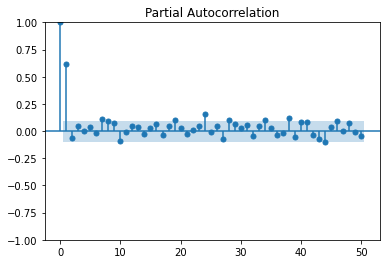

In [63]:
ACF = plot_acf(df_star.mag.dropna(),lags=50)
PACF = plot_pacf(df_star.mag.dropna(),lags=50)

#Step 2 : Fitting AR Model

We calculate the error on the test-set for each p, and pick the best one.

In [65]:
## Cross-validation
best_RMSE=100000000000
best_p = -1

for i in range(1,21):
  [df_train,df_test,theta,intercept,RMSE] = AR(i,pd.DataFrame(df_star.mag))
  if(RMSE<best_RMSE):
    best_RMSE = RMSE
    best_p = i
  
print(best_p)

The RMSE is : 0.1226919887307681 , Value of p :  1
The RMSE is : 0.12435455002504484 , Value of p :  2
The RMSE is : 0.12421378699187106 , Value of p :  3
The RMSE is : 0.1243915160487452 , Value of p :  4
The RMSE is : 0.12354833285848753 , Value of p :  5
The RMSE is : 0.12456774733409826 , Value of p :  6
The RMSE is : 0.1244730885161781 , Value of p :  7
The RMSE is : 0.1228305640213267 , Value of p :  8
The RMSE is : 0.12247225413120576 , Value of p :  9
The RMSE is : 0.12451122767265708 , Value of p :  10
The RMSE is : 0.1257331140182544 , Value of p :  11
The RMSE is : 0.12653055652254963 , Value of p :  12
The RMSE is : 0.12572752759698824 , Value of p :  13
The RMSE is : 0.12732973761261496 , Value of p :  14
The RMSE is : 0.12740317346029845 , Value of p :  15
The RMSE is : 0.12726974509514286 , Value of p :  16
The RMSE is : 0.12797457175901436 , Value of p :  17
The RMSE is : 0.12880335815479516 , Value of p :  18
The RMSE is : 0.12640706515719416 , Value of p :  19
The RMS

In [48]:
[df_train,df_test,theta,intercept,RMSE] = AR(best_p,pd.DataFrame(df_star.mag))

The RMSE is : 0.12247225413120576 , Value of p :  9


In [49]:
df_train['mag']

9     -5.251760
10    -5.268424
11    -5.063218
12    -4.809374
13    -4.901856
         ...   
285   -4.779409
286   -4.976049
287   -5.295079
288   -4.952213
289   -5.282718
Name: mag, Length: 281, dtype: float64

In [50]:
df_test

,mag,Shifted_mag_1,Shifted_mag_2,Shifted_mag_3,Shifted_mag_4,Shifted_mag_5,Shifted_mag_6,Shifted_mag_7,Shifted_mag_8,Shifted_mag_9,Predicted_Values
290,-5.323358,-5.282718,-4.952213,-5.295079,-4.976049,-4.779409,-4.741976,-4.851568,-4.954582,-4.888521,-5.195393
291,-5.228057,-5.323358,-5.282718,-4.952213,-5.295079,-4.976049,-4.779409,-4.741976,-4.851568,-4.954582,-5.157477
292,-5.170479,-5.228057,-5.323358,-5.282718,-4.952213,-5.295079,-4.976049,-4.779409,-4.741976,-4.851568,-5.109426
293,-4.987428,-5.170479,-5.228057,-5.323358,-5.282718,-4.952213,-5.295079,-4.976049,-4.779409,-4.741976,-5.018301
294,-4.913879,-4.987428,-5.170479,-5.228057,-5.323358,-5.282718,-4.952213,-5.295079,-4.976049,-4.779409,-4.988994
...,...,...,...,...,...,...,...,...,...,...,...
410,-5.130105,-5.063023,-4.995724,-4.964434,-5.019845,-5.075255,-5.130666,-5.110066,-5.145705,-5.051431,-5.038601
411,-5.146885,-5.130105,-5.063023,-4.995724,-4.964434,-5.019845,-5.075255,-5.130666,-5.110066,-5.145705,-5.093119
412,-4.715542,-5.146885,-5.130105,-5.063023,-4.995724,-4.964434,-5.019845,-5.075255,-5.130666,-5.110066,-5.093183
413,-5.053955,-4.715542,-5.146885,-5.130105,-5.063023,-4.995724,-4.964434,-5.019845,-5.075255,-5.130666,-4.802075


In [51]:
df_c = pd.concat([df_train,df_test])
df_c

,mag,Shifted_mag_1,Shifted_mag_2,Shifted_mag_3,Shifted_mag_4,Shifted_mag_5,Shifted_mag_6,Shifted_mag_7,Shifted_mag_8,Shifted_mag_9,Predicted_Values
9,-5.251760,-5.257444,-5.280096,-5.302748,-5.196272,-4.803603,-5.207772,-5.230566,-5.277673,-5.015000,-5.127478
10,-5.268424,-5.251760,-5.257444,-5.280096,-5.302748,-5.196272,-4.803603,-5.207772,-5.230566,-5.277673,-5.208152
11,-5.063218,-5.268424,-5.251760,-5.257444,-5.280096,-5.302748,-5.196272,-4.803603,-5.207772,-5.230566,-5.138925
12,-4.809374,-5.063218,-5.268424,-5.251760,-5.257444,-5.280096,-5.302748,-5.196272,-4.803603,-5.207772,-5.016958
13,-4.901856,-4.809374,-5.063218,-5.268424,-5.251760,-5.257444,-5.280096,-5.302748,-5.196272,-4.803603,-4.850907
...,...,...,...,...,...,...,...,...,...,...,...
410,-5.130105,-5.063023,-4.995724,-4.964434,-5.019845,-5.075255,-5.130666,-5.110066,-5.145705,-5.051431,-5.038601
411,-5.146885,-5.130105,-5.063023,-4.995724,-4.964434,-5.019845,-5.075255,-5.130666,-5.110066,-5.145705,-5.093119
412,-4.715542,-5.146885,-5.130105,-5.063023,-4.995724,-4.964434,-5.019845,-5.075255,-5.130666,-5.110066,-5.093183
413,-5.053955,-4.715542,-5.146885,-5.130105,-5.063023,-4.995724,-4.964434,-5.019845,-5.075255,-5.130666,-4.802075


ValueError: x and y must have same first dimension, but have shapes (273,) and (281,)

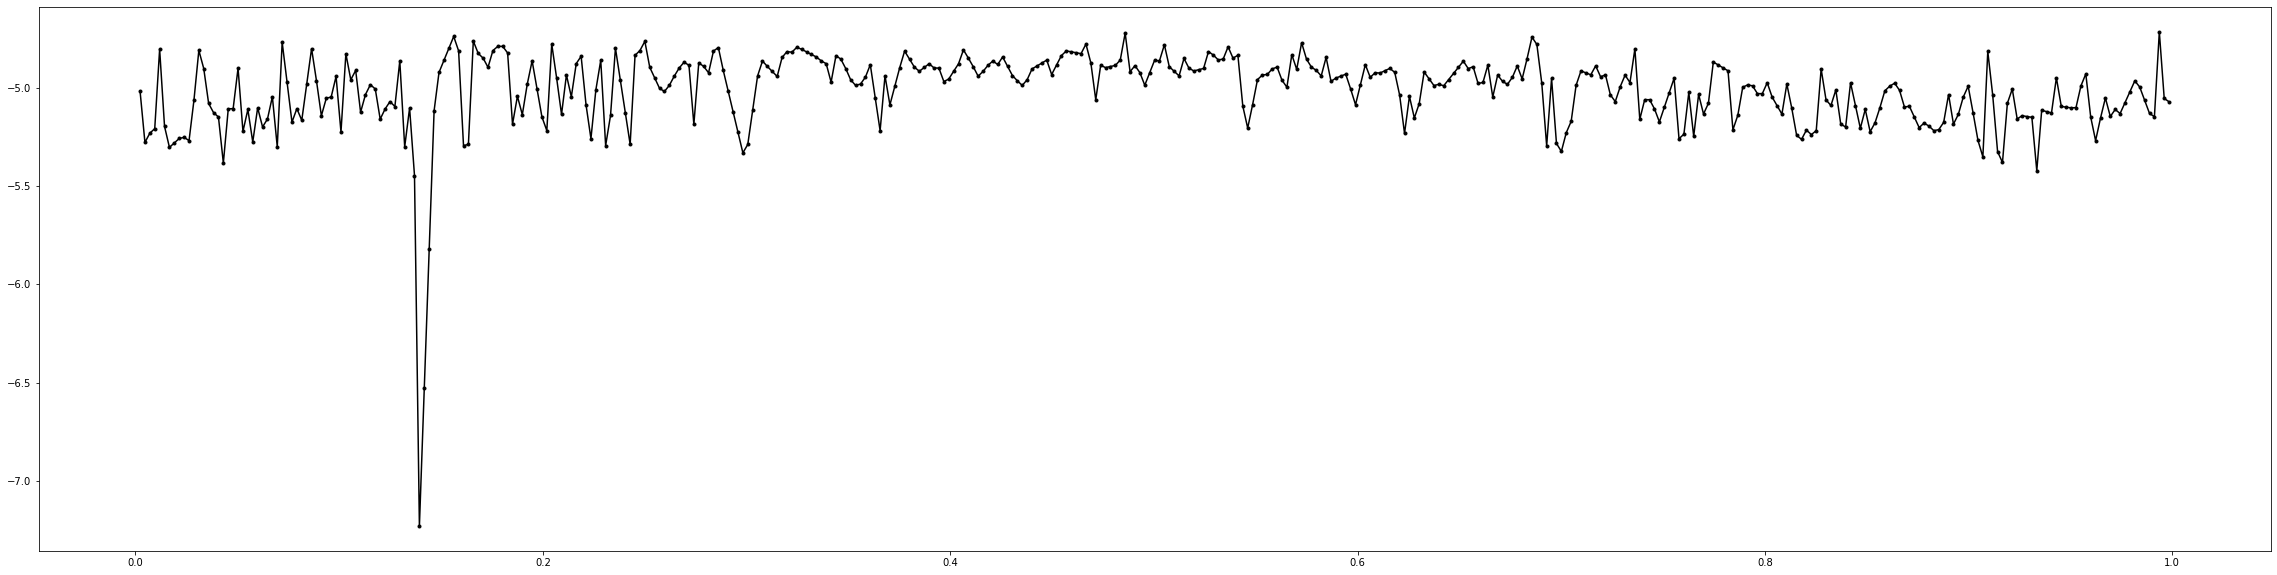

In [57]:
# title = star
plt.figure(figsize = (40,10))
plt.plot(df_star['phase'],df_star['mag'], '.-', color = 'black', label = 'original') #.-
plt.plot(df_star['phase'][:len(df_train['mag'])],df_c['Predicted_Values'][:len(df_train['mag'])], '.-', color = 'red', label = 'train') # 
plt.plot(df_star['phase'][len(df_train['mag']):], df_c['Predicted_Values'][len(df_train['mag']):], '.-', color = 'blue', label = 'forecast_test') #
plt.legend(loc='best')
plt.ylabel('magnitud')
plt.xlabel('period [phase]')
# plt.title(str(title))
plt.tick_params(labelrotation=45)
plt.text.usetex = True
plt.savefig(fname = 'exampleserie.svg')
plt.show()

Generating the residuals for MA

In [22]:
res = pd.DataFrame()
res['Residuals'] = df_c.mag - df_c.Predicted_Values

In [23]:
res

,Residuals
1,0.647416
2,-0.159201
3,0.343611
4,-0.598500
5,1.958417
...,...
411,-0.452247
412,0.098378
413,0.063208
414,-0.164070


<AxesSubplot:ylabel='Density'>

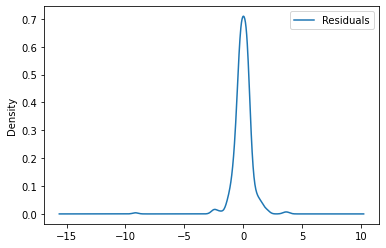

In [24]:
res.plot(kind='kde')

#Step 3 : Fitting MA on Residuals

The RMSE is : 1.2676714126809632 , Value of q :  1
The RMSE is : 1.319717338541425 , Value of q :  2
The RMSE is : 1.326618375941989 , Value of q :  3
The RMSE is : 1.3242474557456565 , Value of q :  4
The RMSE is : 1.3221859050888167 , Value of q :  5
The RMSE is : 1.3267238100742502 , Value of q :  6
The RMSE is : 1.3264623269101046 , Value of q :  7
The RMSE is : 1.3319603284824357 , Value of q :  8
The RMSE is : 1.3324729766809411 , Value of q :  9
The RMSE is : 1.3296394626122878 , Value of q :  10
The RMSE is : 1.3285803041440063 , Value of q :  11
The RMSE is : 1.3298528401483594 , Value of q :  12
1


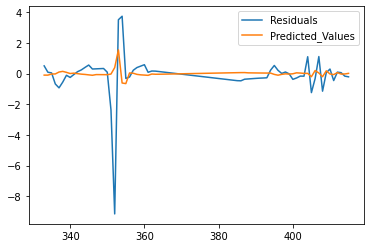

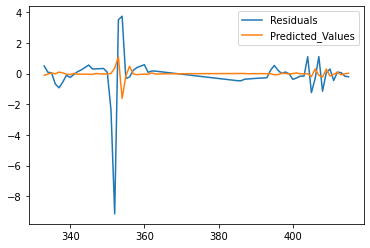

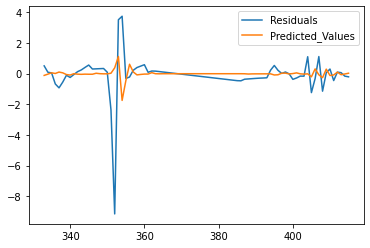

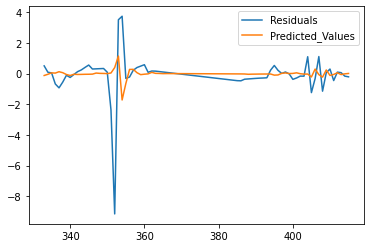

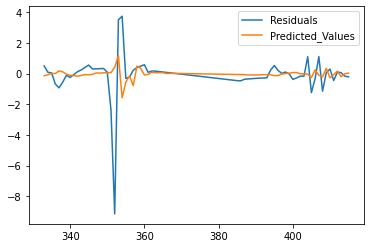

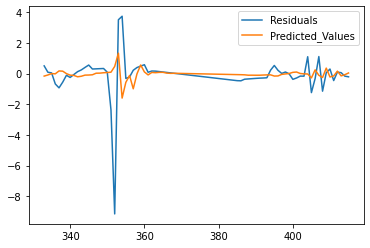

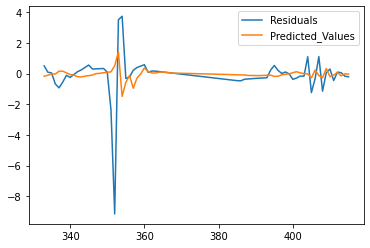

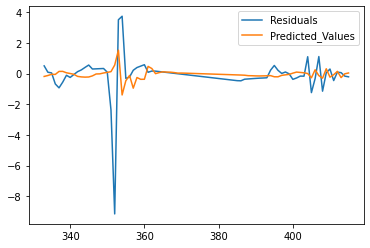

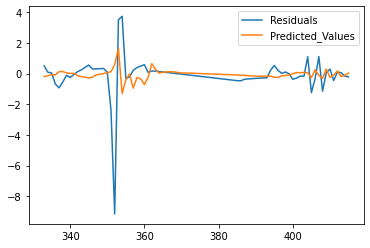

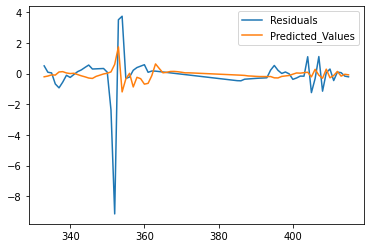

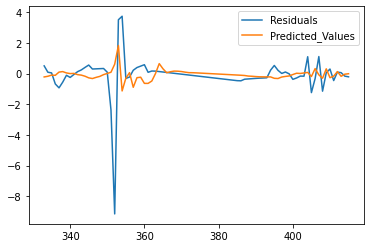

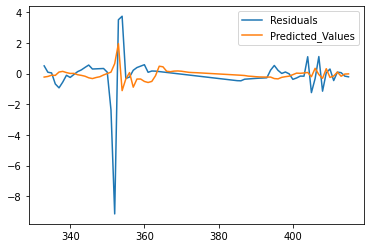

In [25]:
best_RMSE=100000000000
best_q = -1

for i in range(1,13):
  [res_train,res_test,theta,intercept,RMSE] = MA(i,pd.DataFrame(res.Residuals))
  if(RMSE<best_RMSE):
    best_RMSE = RMSE
    best_q = i
  
print(best_q)

The RMSE is : 1.2676714126809632 , Value of q :  1
[[-0.17075336]]
[-0.01099839]


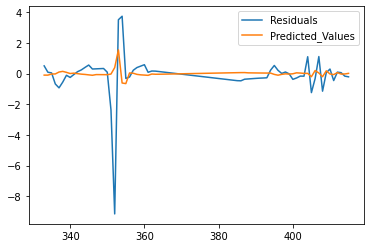

In [230]:
[res_train,res_test,theta,intercept,RMSE] = MA(best_q,pd.DataFrame(res.Residuals))
print(theta)
print(intercept)

In [26]:
res_c = pd.concat([res_train,res_test])

In [27]:
res_c

,Residuals,Shifted_values_1,Shifted_values_2,Shifted_values_3,Shifted_values_4,Shifted_values_5,Shifted_values_6,Shifted_values_7,Shifted_values_8,Shifted_values_9,Shifted_values_10,Shifted_values_11,Shifted_values_12,Predicted_Values
13,-0.537621,-0.919511,-0.725011,0.145593,0.219192,0.264221,0.309249,0.354278,1.958417,-0.598500,0.343611,-0.159201,0.647416,0.360549
14,1.373757,-0.537621,-0.919511,-0.725011,0.145593,0.219192,0.264221,0.309249,0.354278,1.958417,-0.598500,0.343611,-0.159201,0.280589
15,-0.153606,1.373757,-0.537621,-0.919511,-0.725011,0.145593,0.219192,0.264221,0.309249,0.354278,1.958417,-0.598500,0.343611,-0.073661
16,0.258785,-0.153606,1.373757,-0.537621,-0.919511,-0.725011,0.145593,0.219192,0.264221,0.309249,0.354278,1.958417,-0.598500,0.286552
17,-0.209865,0.258785,-0.153606,1.373757,-0.537621,-0.919511,-0.725011,0.145593,0.219192,0.264221,0.309249,0.354278,1.958417,-0.072318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,-0.452247,0.299648,0.060647,-1.145671,1.114333,-0.320268,-1.239188,1.104171,-0.166235,-0.160752,-0.283390,-0.372952,-0.013558,-0.153958
412,0.098378,-0.452247,0.299648,0.060647,-1.145671,1.114333,-0.320268,-1.239188,1.104171,-0.166235,-0.160752,-0.283390,-0.372952,0.102511
413,0.063208,0.098378,-0.452247,0.299648,0.060647,-1.145671,1.114333,-0.320268,-1.239188,1.104171,-0.166235,-0.160752,-0.283390,-0.169111
414,-0.164070,0.063208,0.098378,-0.452247,0.299648,0.060647,-1.145671,1.114333,-0.320268,-1.239188,1.104171,-0.166235,-0.160752,-0.027478


In [28]:
df_c.Predicted_Values += res_c.Predicted_Values

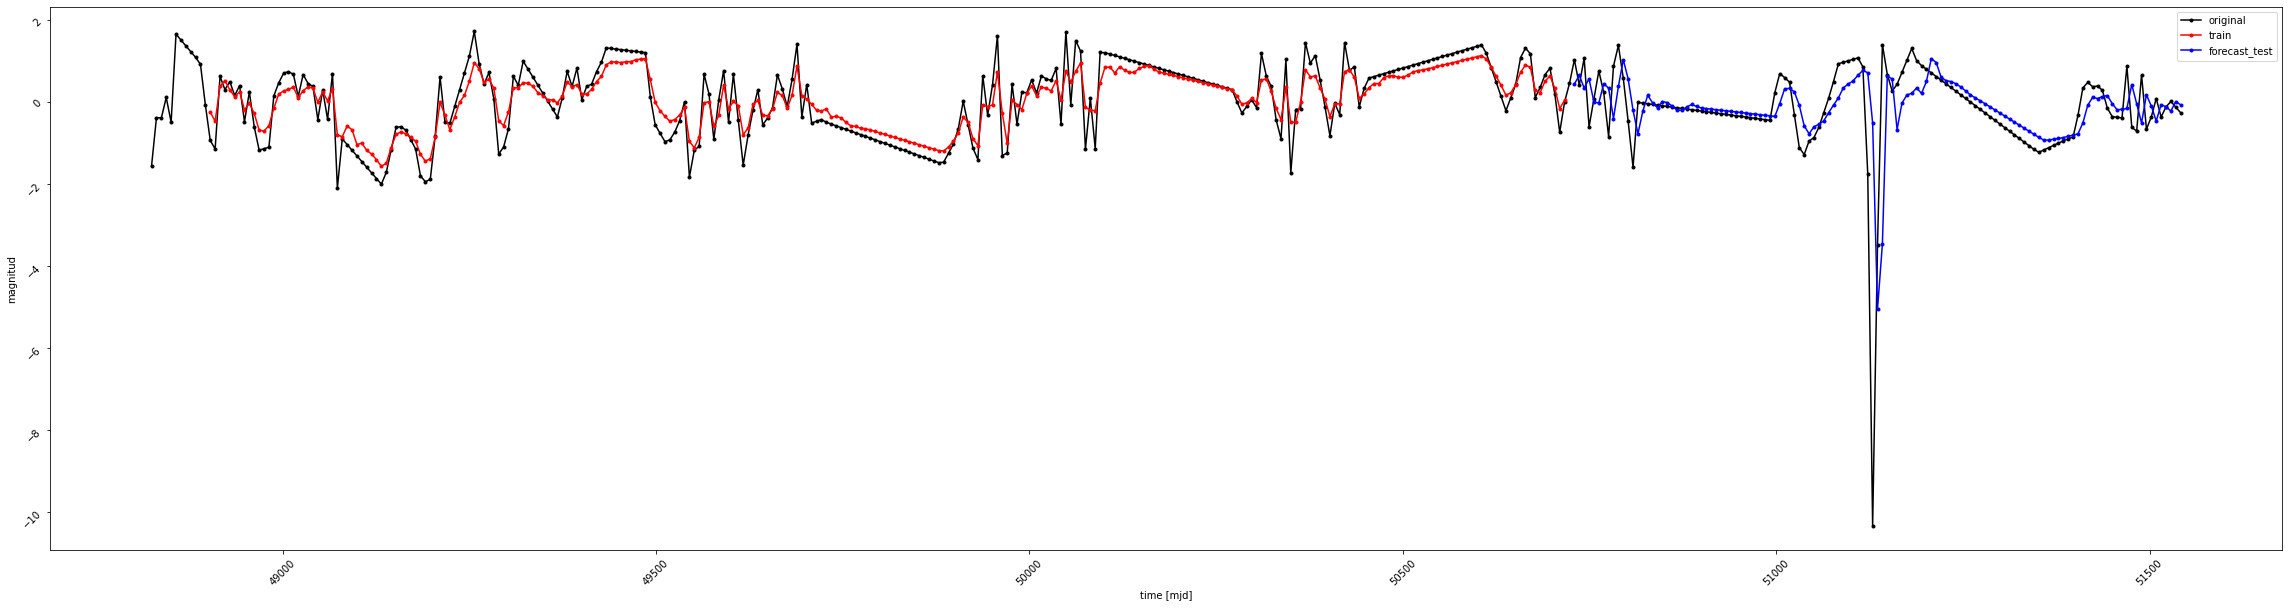

In [29]:
plt.figure(figsize = (40,10))
plt.plot(df_star['mjd'],df_star['mag'], '.-', color = 'black', label = 'original') #.-
plt.plot(df_star['mjd'][:len(df_train['mag'])],df_c['Predicted_Values'][:len(df_train['mag'])], '.-', color = 'red', label = 'train') # 
plt.plot(df_star['mjd'][len(df_train['mag'])+1:], df_c['Predicted_Values'][len(df_train['mag']):], '.-', color = 'blue', label = 'forecast_test') #
plt.legend(loc='best')
plt.ylabel('magnitud')
plt.xlabel('time [mjd]')
# plt.title(str(title))
plt.tick_params(labelrotation=45)
plt.text.usetex = True
plt.savefig(fname = 'exampleserie.svg')
plt.show()

<AxesSubplot:>

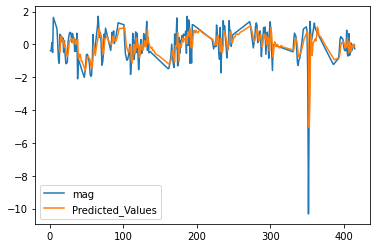

In [30]:
df_c[['mag','Predicted_Values']].plot()

# Step 4 : Getting Back Original data

Reversing the steps performed for differencing, as a check the first column (Value) must be the same after reversing the steps.

In [239]:
df_c.mag += (df_star).shift(1).mag
# df_c.mag += (df_star).diff().shift(12).mag ## solo se realiza si se diferencia 12.
df_c.Predicted_Values += (df_star).shift(1).mag
df_c.Predicted_Values += (df_star).diff().shift(12).mag
df_c.Predicted_Values = (df_c.Predicted_Values)

In [31]:
df_c

,mag,Shifted_mag_1,Predicted_Values
1,-0.380983,-1.553701,NaN
2,-0.388293,-0.380983,NaN
3,0.109537,-0.388293,NaN
4,-0.493260,0.109537,NaN
5,1.652798,-0.493260,NaN
...,...,...,...
411,-0.364563,0.083779,-0.066274
412,-0.119522,-0.364563,-0.115389
413,0.012324,-0.119522,-0.219995
414,-0.125089,0.012324,0.011502


<AxesSubplot:>

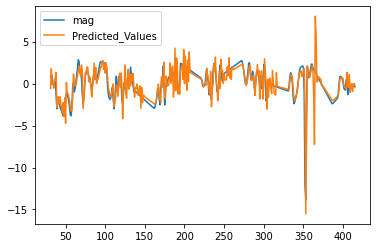

In [241]:
df_c.iloc[30:,:][['mag','Predicted_Values']].plot()